# Preamble (adopted from ncrystal-notebook)

In [1]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    %pip -q install ncrystal[plot] ipympl
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
    %matplotlib inline
else:
    %matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  4000000, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


# Extinction and texture plugins

In [2]:
%pip install "git+https://github.com/XuShuqi7/ncplugin-CrysExtn"

  Cloning https://github.com/XuShuqi7/ncplugin-CrysExtn to /tmp/pip-req-build-rygjqdnv
  Running command git clone --filter=blob:none --quiet https://github.com/XuShuqi7/ncplugin-CrysExtn /tmp/pip-req-build-rygjqdnv
  Resolved https://github.com/XuShuqi7/ncplugin-CrysExtn to commit 31475d01c422a19de19f3b7d9845b38247ab8ad5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
%pip install "git+https://github.com/highness-eu/ncplugin-CrysText"

  Cloning https://github.com/highness-eu/ncplugin-CrysText to /tmp/pip-req-build-acmp2s59
  Running command git clone --filter=blob:none --quiet https://github.com/highness-eu/ncplugin-CrysText /tmp/pip-req-build-acmp2s59
  Resolved https://github.com/highness-eu/ncplugin-CrysText to commit 276f662f19df9f1acd2eeb66a8296ddd0332db67
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


# Necessary packages

In [4]:
%pip -q install lmfit spglib

In [5]:
import numpy as np
from scipy import special, integrate
import re
from lmfit import Model
from lmfit.model import save_modelresult
import matplotlib.pyplot as plt

# Jorgensen resolution function to be convolved

In [6]:
def jorgensen_vectorized(x, d, a0, a1, b0, b1, s02, s12, s22):
    """Vectorized Jorgensen function for faster evaluation."""

    # Calculate common factors
    alpha = a0 + a1 / d
    beta = b0 + b1 / d**4
    sigma2 = s02 + s12 * d**2 + s22 * d**4
    Delta = -(x - 2 * d)

    # Precompute for efficiency
    sqrt_2_sigma2 = np.sqrt(2 * sigma2)

    y = (alpha * sigma2 + Delta) / sqrt_2_sigma2
    z = (beta * sigma2 - Delta) / sqrt_2_sigma2
    u = 0.5 * alpha * (alpha * sigma2 + 2 * Delta)
    v = 0.5 * beta * (beta * sigma2 - 2 * Delta)

    # Efficient computation of uy and vz
    uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
    vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))

    # Final result
    F = 0.5 * alpha * beta / (alpha + beta) * (uy + vz)

    return F

# Convolution function

In [7]:
def convolve_optimized(x, f, a0, a1, b0, b1, s02, s12, s22):
    '''f : function to be convolved with an asymmetric Gaussian
    x : variable of f, equidistant
    '''
    assert len(f) > 2

    # Initialize result array
    fres = np.zeros_like(f)

    # Precompute constant step size
    dx = x[1] - x[0]

    # Precompute half of x[i] once
    x_half = 0.5 * x

    # Perform convolution using vectorization
    for i in range(len(f)):
        # Compute jorgensen values for all x[j] at once (vectorized)
        F = jorgensen_vectorized(x, x_half[i], a0, a1, b0, b1, s02, s12, s22)

        # Perform the sum excluding boundary points
        fres[i] = np.sum(f[1:-1] * F[1:-1])

        # Handle boundary points separately
        F0 = jorgensen_vectorized(x[0], x_half[i], a0, a1, b0, b1, s02, s12, s22)
        FN = jorgensen_vectorized(x[-1], x_half[i], a0, a1, b0, b1, s02, s12, s22)
        fres[i] += 0.5 * (f[0] * F0 + f[-1] * FN)

    # Multiply the result by dx (constant step size)
    fres *= dx

    return fres

# Convert weight fraction to volumn fraction

In [8]:
def calc_compo(elem_list, wts, base_element='Fe'):
    """
    Calculate atomic composition from weight percentages and ensure the sum after rounding is exactly 1.

    Parameters:
        elem_list (list of str): List of element symbols.
        wts (list of float): Corresponding weight percentages.
        base_element (str): The base element to make up the remaining composition (default: 'Fe').

    Returns:
        str: A formatted string of atomic fractions where the sum is exactly 1.000.
    """
    if len(elem_list) != len(wts):
        raise ValueError("Element list and weight list must have the same length.")

    total_wt = np.sum(wts)

    if total_wt > 100:
        raise ValueError("Total weight percentage exceeds 100%.")

    # Compute the missing base element weight
    base_wt = 100 - total_wt

    # Ensure base element is not duplicated in the list
    if base_element in elem_list:
        index = elem_list.index(base_element)
        wts[index] += base_wt  # Add the remaining weight to the existing base element
        elem_list_new = np.array(elem_list)
        wts_new = np.array(wts)
    else:
        elem_list_new = np.append(elem_list, base_element)
        wts_new = np.append(wts, base_wt)

    # Calculate atomic fractions
    atomic_wts = np.array([
        w / NC.atomDB(NC.atomdata.elementNameToZValue(e)).averageMassAMU()
        for e, w in zip(elem_list_new, wts_new)
    ])

    # Normalize to sum to 1
    atomic_wts /= np.sum(atomic_wts)

    # Round to 3 decimal places and ensure sum is exactly 1
    rounded_atomic_wts = np.round(atomic_wts, 3)
    rounding_error = 1.000 - np.sum(rounded_atomic_wts)

    # Adjust the last element to fix rounding error
    rounded_atomic_wts[-1] += rounding_error

    # Format the output string
    result = " ".join(f"{wt:.3f} {elem}" for elem, wt in zip(elem_list_new, rounded_atomic_wts))

    print(result)
    return result  # Returning it allows reuse elsewhere

# Replace lattice parameter

In [9]:
def re_lat(lines, lat):
    # Flags to control the replacement logic
    found_cell = False

    # Process each line
    for i, line in enumerate(lines):
        # Skip comment lines (starting with #)
        if line.strip().startswith("#"):
            continue

        # Check for the @CELL\n line
        if "@CELL" in line:
            found_cell = True
            continue

        # If @CELL\n was found, look for the next "cubic" line
        if found_cell and "cubic" in line:
            # Use regex to replace the float number after "cubic"
            # Account for leading spaces and the float number
            lines[i] = re.sub(r'(\s*cubic\s+)[\d\.]+', r'\g<1>{}'.format(lat), line)
            break  # Stop after replacing the first occurrence

    return lines

# Calculation of time-of-flight transmission based on the given parameters

## Duplex Steel

In [10]:
def calcDplTrans(t, ZERO, DIFC, thk, scl, phfr,
                 temp, lat1, lat2, addthk,
                 l, g, L,
                 alp0, alp1, bet0, bet1, sig0, sig1, sig2,
                 wl_ext=0.1, ncmatFile='Fe_sg229_Iron-alpha.ncmat',
                 second_phase='Fe_sg225_Iron-gamma.ncmat',
                 density = 7.8,
                 atomdb = '',
                 add_ncmat = 'Polyethylene_CH2.ncmat',
                 ExtModel='BC_mix',
                 NPTS=1400,
                 Resolution=False):

    '''Working for one transmission
    '''

    trans    = np.empty_like(t)
    trans[:] = np.nan

    # convert to wavelength
    wl = (t - ZERO) / DIFC

    # Get a uniform grid for the convolution
    # Calculated over larger range than the experimental data to remove edge effects
    wl_convolve = np.linspace(wl[0] - wl_ext, wl[-1] + wl_ext + 0.1, NPTS)

    ekinE = NC.wl2ekin(wl_convolve)

    baseFile = 'base.ncmat'
    c = NC.NCMATComposer(ncmatFile)
    c.write(baseFile)
    with open(baseFile, "r") as src:
        src_lines = src.readlines()
    src_lines = re_lat(src_lines, lat1)
    with open(baseFile, "w") as dest:
        dest.writelines(src_lines)  # Reads entire content and writes it

    # --- Model options
    if ExtModel == 'Sabine_corr':
        with open(baseFile, 'a') as f:
            f.write('@CUSTOM_CRYSEXTN\n')
            f.write('  {}  {}  {}  {}  \n'.format(ExtModel, l, g, L))
    elif ExtModel == 'Sabine_uncorr':
        with open(baseFile, 'a') as f:
            f.write('@CUSTOM_CRYSEXTN\n')
            f.write('  {}  {}  {}  {}  rect  \n'.format(ExtModel, l, g, L))
    elif ExtModel == 'BC_pure' or ExtModel == 'BC_mix' or ExtModel == 'BC_mod':
        with open(baseFile, 'a') as f:
            f.write('@CUSTOM_CRYSEXTN\n')
            f.write('  {}  {}  {}  {}  Gauss  \n'.format(ExtModel, l, g, L))
    else:
        print('Incorrect model option selection')

    secondFile = 'sndphase.ncmat'
    c2 = NC.NCMATComposer(second_phase)
    c2.write(secondFile)
    with open(secondFile, "r") as src:
        src_lines = src.readlines()
    src_lines = re_lat(src_lines, lat2)
    with open(secondFile, "w") as dest:
        dest.writelines(src_lines)  # Reads entire content and writes it

    mixphasecfg = 'phases<{}*base.ncmat&{}*sndphase.ncmat>;{};temp={}K;density={}gcm3'.format(phfr, 1-phfr, atomdb, temp, density)

    pc   = NC.createScatter(mixphasecfg)
    pc_a = NC.createAbsorption(mixphasecfg)
    info = NC.createInfo(mixphasecfg)

    xsect = pc.crossSectionIsotropic(ekinE) + pc_a.crossSectionIsotropic(ekinE)

    # additional layer material
    ADD     = NC.createScatter(add_ncmat)
    ADDa    = NC.createAbsorption(add_ncmat)
    ADDinfo = NC.createInfo(add_ncmat)

    xsect_ADD  = ADD.crossSectionIsotropic(ekinE) + ADDa.crossSectionIsotropic(ekinE)

    trans_ncrystal = np.exp(-xsect * info.numberdensity * thk - xsect_ADD * ADDinfo.numberdensity * addthk)

    if Resolution:
        trans_ncrystal = convolve_optimized(wl_convolve, trans_ncrystal, alp0, alp1, bet0, bet1, sig0, sig1, sig2)

    #return to the grid used in the experimental data
    trans = np.interp(wl, wl_convolve, trans_ncrystal)

    #including a scaling factor
    trans *= scl

    print('One calculation finished.')

    return trans

## Austenite

In [11]:
def calcAtnTransText(t, ZERO, DIFC, thk, scl,
                     temp, lat,
                     f, R1, R2,
                     alp0, alp1, bet0, bet1, sig0, sig1, sig2,
                     wl_ext=0.1, ncmatFile='Fe_sg225_Iron-gamma.ncmat',
                     density = 7.8,
                     atomdb = 'atomdb=Fe:is:0.156:Cr:0.238:Ni:0.024:Ti:0.007:Mo:0.002:Mn:0.004:Si:0.003:V:0.003:Al:0.563:Fe',
                     POs = [[1,1,1],[2,0,0]],
                     NPTS=1400,
                     Resolution=False):

    '''Working for one transmission
    '''

    trans    = np.empty_like(t)
    trans[:] = np.nan

    # convert to wavelength
    wl = (t - ZERO) / DIFC

    # Get a uniform grid for the convolution
    # Calculated over larger range than the experimental data to remove edge effects
    wl_convolve = np.linspace(wl[0] - wl_ext, wl[-1] + wl_ext + 0.1, NPTS)

    ekinE = NC.wl2ekin(wl_convolve)

    baseFile = 'base.ncmat'
    c = NC.NCMATComposer(ncmatFile)
    c.write(baseFile)
    with open(baseFile, "r") as src:
        src_lines = src.readlines()
    src_lines = re_lat(src_lines, lat)
    with open(baseFile, "w") as dest:
        dest.writelines(src_lines)  # Reads entire content and writes it

    with open(baseFile, 'a') as bf:
        bf.write('@CUSTOM_CRYSTEXT\n')
        bf.write('  {:d}  {:d}  {:d}  {}  {}  \n'.format(int(POs[0,0]),int(POs[0,1]),int(POs[0,2]),R1,f))
        bf.write('  {:d}  {:d}  {:d}  {}  {}  \n'.format(int(POs[1,0]),int(POs[1,1]),int(POs[1,2]),R2,1.0-f))

    cfg = 'base.ncmat;{};temp={}K;density={}gcm3'.format(atomdb, temp, density)

    pc   = NC.createScatter(cfg)
    pc_a = NC.createAbsorption(cfg)
    info = NC.createInfo(cfg)

    xsect = pc.crossSectionIsotropic(ekinE) + pc_a.crossSectionIsotropic(ekinE)

    trans_ncrystal = np.exp(-xsect * info.numberdensity * thk)

    if Resolution:
        trans_ncrystal = convolve_optimized(wl_convolve, trans_ncrystal, alp0, alp1, bet0, bet1, sig0, sig1, sig2)

    #return to the grid used in the experimental data
    trans = np.interp(wl, wl_convolve, trans_ncrystal)

    #including a scaling factor
    trans *= scl

    print('One calculation finished.')

    return trans

# Fitting procedure begins here...

## Example: Duplex transmission data measured at the IMAT@ISIS

In [12]:
#Data to be fit (wavelength, intensity, uncertainty)
txt = """1.597528684907325580e+00 4.428900446122401857e-01 2.391627643570329309e-03
1.606354810238305397e+00 4.420883709912033499e-01 2.382447892248397772e-03
1.615180935569284992e+00 4.409793345670293685e-01 2.365253617407112735e-03
1.624007060900264809e+00 4.551615449595606266e-01 2.395918237628950724e-03
1.632833186231244404e+00 4.464952713504727888e-01 2.357833145008164048e-03
1.641659311562224222e+00 4.460547692622572336e-01 2.343803605871195867e-03
1.650485436893203817e+00 4.448556350682476568e-01 2.324898737451353611e-03
1.659311562224183634e+00 4.472561272603952087e-01 2.319268772357466375e-03
1.668137687555163229e+00 4.536258585334191351e-01 2.324856067746141740e-03
1.676963812886143046e+00 4.629289692040536863e-01 2.333576607945378033e-03
1.685789938217122641e+00 4.540218125292082019e-01 2.295950182466739795e-03
1.694616063548102458e+00 4.608871251063451635e-01 2.304364149164997780e-03
1.703442188879082053e+00 4.568810046637517552e-01 2.280505439391516172e-03
1.712268314210061870e+00 4.514561847882134216e-01 2.247663464381005009e-03
1.721094439541041465e+00 4.461654988611245543e-01 2.217600206479583558e-03
1.729920564872021282e+00 4.486528353075094344e-01 2.215072541723214251e-03
1.738746690203000878e+00 4.476889839337360733e-01 2.204471339614757705e-03
1.747572815533980473e+00 4.441661882361759850e-01 2.177996073640898252e-03
1.756398940864960290e+00 4.424125132476831035e-01 2.158516182348671833e-03
1.765225066195939885e+00 4.419813087832357157e-01 2.147164110519584387e-03
1.774051191526919702e+00 4.383304323663925750e-01 2.126565016842470960e-03
1.782877316857899297e+00 4.375458525186400882e-01 2.114389243515177146e-03
1.791703442188879114e+00 4.339831374637925232e-01 2.088115141975772047e-03
1.800529567519858709e+00 4.377375844775699409e-01 2.084232590848435381e-03
1.809355692850838526e+00 4.289419261258407556e-01 2.049357567519059006e-03
1.818181818181818121e+00 4.335823377333379858e-01 2.046476507751178106e-03
1.827007943512797938e+00 4.378366725794662351e-01 2.041992292639231276e-03
1.835834068843777533e+00 4.447917592903238848e-01 2.043827598456795635e-03
1.844660194174757351e+00 4.455657488589479520e-01 2.036178407167832036e-03
1.853486319505736946e+00 4.400692073430513829e-01 2.002804946668693912e-03
1.862312444836716763e+00 4.415536759213701812e-01 1.994526549157445584e-03
1.871138570167696358e+00 4.347569071523630369e-01 1.958240164202066855e-03
1.879964695498676175e+00 4.374677901093577681e-01 1.950333902749913726e-03
1.888790820829655770e+00 4.391484800998855520e-01 1.939189528875583319e-03
1.897616946160635587e+00 4.324013543192292142e-01 1.910153906163654684e-03
1.906443071491615182e+00 4.343101141166026968e-01 1.901642125143829807e-03
1.915269196822594777e+00 4.308801755186766891e-01 1.878656313837346551e-03
1.924095322153574594e+00 4.261555237861183731e-01 1.851059412148414740e-03
1.932921447484554189e+00 4.320896206070922729e-01 1.850898310691735053e-03
1.941747572815534006e+00 4.251701491728087645e-01 1.824301616853376716e-03
1.950573698146513602e+00 4.228937039711677670e-01 1.803992418445305454e-03
1.959399823477493419e+00 4.216609802609781465e-01 1.786099473293528044e-03
1.968225948808473014e+00 4.223774902984180346e-01 1.775614840397773085e-03
1.977052074139452831e+00 4.199151695774644977e-01 1.753792770750668912e-03
1.985878199470432426e+00 4.155087704740704213e-01 1.729530019547210595e-03
1.994704324801412243e+00 4.156818792499088477e-01 1.718069207051297134e-03
2.003530450132391838e+00 4.117222131235493965e-01 1.694191667271235067e-03
2.012356575463371655e+00 4.125520602142471183e-01 1.682235444718759455e-03
2.021182700794351472e+00 4.097358616592834402e-01 1.663954875198927260e-03
2.030008826125330845e+00 4.055083165614715157e-01 1.639680245327504969e-03
2.038834951456310662e+00 4.065470628397819808e-01 1.624936208837778886e-03
2.047661076787290479e+00 4.111587742709227888e-01 1.621409489364415615e-03
2.056487202118270297e+00 4.093351555630634353e-01 1.604133362900129860e-03
2.065313327449249670e+00 4.070066962510957564e-01 1.588762408747330110e-03
2.074139452780229487e+00 4.073747299353319140e-01 1.573609336916664174e-03
2.082965578111209304e+00 4.041032210343347142e-01 1.552166958820187315e-03
2.091791703442188677e+00 4.082882219450592043e-01 1.549904194421001602e-03
2.100617828773168494e+00 4.103922565094320074e-01 1.538711486692091474e-03
2.109443954104148311e+00 4.100280670937638261e-01 1.524877293624226065e-03
2.118270079435128128e+00 4.087950276188444532e-01 1.509099038696617599e-03
2.127096204766107501e+00 4.083345561365467336e-01 1.493063370003516526e-03
2.135922330097087318e+00 4.080868550764417124e-01 1.477708386030717694e-03
2.144748455428067135e+00 4.035002579748613871e-01 1.454600236435796192e-03
2.153574580759046952e+00 4.034704251211942427e-01 1.444648631221404555e-03
2.162400706090026326e+00 4.011523061728495265e-01 1.423736668377078391e-03
2.171226831421006143e+00 4.006613171242589533e-01 1.411857107578936947e-03
2.180052956751985960e+00 4.012889402955162610e-01 1.398610460591194742e-03
2.188879082082965777e+00 4.173266486679479415e-01 1.416264356186261236e-03
2.197705207413945150e+00 4.214015349994592041e-01 1.409183584903001300e-03
2.206531332744924967e+00 4.201556165389395692e-01 1.394187353057305253e-03
2.215357458075904784e+00 4.251551202016622399e-01 1.390784535851894268e-03
2.224183583406884157e+00 4.229912300905361300e-01 1.371736832031729891e-03
2.233009708737863974e+00 4.241469415733791215e-01 1.361314161889839829e-03
2.241835834068843791e+00 4.237006572011816075e-01 1.346958522121941048e-03
2.250661959399823608e+00 4.200494929298677627e-01 1.325326160201625554e-03
2.259488084730802981e+00 4.192839433399841997e-01 1.311824424691829510e-03
2.268314210061782799e+00 4.188449235987757868e-01 1.298052709335308433e-03
2.277140335392762616e+00 4.159515481060989672e-01 1.280325728426035979e-03
2.285966460723742433e+00 4.152743093288177589e-01 1.265818430133513811e-03
2.294792586054721806e+00 4.145558077080319093e-01 1.255022097132385637e-03
2.303618711385701623e+00 4.132968972409400976e-01 1.241188759461842430e-03
2.312444836716681440e+00 4.117366496740723081e-01 1.231450517003674933e-03
2.321270962047661257e+00 4.098195404619703885e-01 1.217955002872929925e-03
2.330097087378640630e+00 4.071662138606244041e-01 1.203182462553076693e-03
2.338923212709620447e+00 4.069580964869136674e-01 1.194206962820406042e-03
2.347749338040600264e+00 4.048171930571563548e-01 1.178908362479279444e-03
2.356575463371580081e+00 4.130064792411831109e-01 1.182949844591597594e-03
2.365401588702559454e+00 4.258895242523287883e-01 1.194351779292706283e-03
2.374227714033539272e+00 4.269713105756028915e-01 1.186344865072673201e-03
2.383053839364519089e+00 4.280849608404722617e-01 1.181525022905512449e-03
2.391879964695498462e+00 4.289116319760575835e-01 1.174709847565169217e-03
2.400706090026478279e+00 4.302193707914455656e-01 1.169996471225290095e-03
2.409532215357458096e+00 4.298361934425314335e-01 1.164691823337426482e-03
2.418358340688437913e+00 4.259366022334268864e-01 1.151909112586272342e-03
2.427184466019417286e+00 4.288177550509507663e-01 1.152633239628084432e-03
2.436010591350397103e+00 4.264185062178945662e-01 1.144158264806279055e-03
2.444836716681376920e+00 4.250521564361370852e-01 1.137257079792406214e-03
2.453662842012356737e+00 4.231517319546697631e-01 1.123210418194390062e-03
2.462488967343336110e+00 4.230916772984474883e-01 1.115418662821429869e-03
2.471315092674315927e+00 4.213145293073779496e-01 1.105749082040390378e-03
2.480141218005295745e+00 4.178592075428928521e-01 1.097062358735599596e-03
2.488967343336275562e+00 4.210461371724258384e-01 1.098652847855628896e-03
2.497793468667254935e+00 4.150205223221958839e-01 1.085271886733650765e-03
2.506619593998234752e+00 4.162260942921578444e-01 1.084418860119232969e-03
2.515445719329214569e+00 4.154167107983075535e-01 1.081593253440072365e-03
2.524271844660194386e+00 4.142386336758931975e-01 1.078347849555584635e-03
2.533097969991173759e+00 4.134328303774358337e-01 1.076615936467859589e-03
2.541924095322153576e+00 4.098346427416175164e-01 1.068424969388605955e-03
2.550750220653133393e+00 4.081881537878543909e-01 1.065187974620784460e-03
2.559576345984112766e+00 4.161994615976374878e-01 1.076510696649189431e-03
2.568402471315092583e+00 4.259538606887951495e-01 1.090412839202482701e-03
2.577228596646072400e+00 4.270196887130147112e-01 1.088466686324794479e-03
2.586054721977052218e+00 4.315936069010178899e-01 1.096531844564633488e-03
2.594880847308031591e+00 4.324277306682812183e-01 1.098555184084108174e-03
2.603706972639011408e+00 4.297755894859580095e-01 1.093174517213906611e-03
2.612533097969991225e+00 4.298827903071472112e-01 1.093773207499005966e-03
2.621359223300971042e+00 4.313099351847276552e-01 1.095936242946562653e-03
2.630185348631950415e+00 4.304801079225909488e-01 1.095640337480880636e-03
2.639011473962930232e+00 4.292083120136545027e-01 1.093866844067292819e-03
2.647837599293910049e+00 4.289005737450623523e-01 1.094871408590370604e-03
2.656663724624889866e+00 4.269705621857544098e-01 1.092432032025454506e-03
2.665489849955869239e+00 4.281842997606430390e-01 1.097115814263697987e-03
2.674315975286849056e+00 4.257463733912176806e-01 1.094665593247019959e-03
2.683142100617828874e+00 4.289218996165181097e-01 1.106282793424972306e-03
2.691968225948808691e+00 4.230343273121565106e-01 1.100574502231788706e-03
2.700794351279788064e+00 4.217273060657322215e-01 1.100982453059556150e-03
2.709620476610767881e+00 4.204393029062408194e-01 1.100830925116574183e-03
2.718446601941747698e+00 4.211432957891981244e-01 1.106100876281700899e-03
2.727272727272727071e+00 4.188587852564719660e-01 1.103385554543642039e-03
2.736098852603706888e+00 4.170549895379629390e-01 1.104270380010022009e-03
2.744924977934686705e+00 4.194855740077441664e-01 1.111927176039881858e-03
2.753751103265666522e+00 4.149614017145529243e-01 1.106844303785573360e-03
2.762577228596645895e+00 4.121620145420347714e-01 1.105357326077652681e-03
2.771403353927625712e+00 4.140143594671770733e-01 1.109567588714427139e-03
2.780229479258605529e+00 4.111077577951471329e-01 1.109067293540290421e-03
2.789055604589585347e+00 4.112803642557287809e-01 1.111516798476783066e-03
2.797881729920564720e+00 4.083516335729179825e-01 1.108767514541161500e-03
2.806707855251544537e+00 4.087888023182802977e-01 1.112515364220220942e-03
2.815533980582524354e+00 4.056071369016527872e-01 1.110473686243581334e-03
2.824360105913504171e+00 4.054724944856707425e-01 1.113411152221668345e-03
2.833186231244483544e+00 4.028566736406750670e-01 1.113541900537697157e-03
2.842012356575463361e+00 4.020498725742883694e-01 1.115055957222961048e-03
2.850838481906443178e+00 4.007198763199049107e-01 1.116785135789297037e-03
2.859664607237422551e+00 4.022805284060920195e-01 1.123536725281030829e-03
2.868490732568402368e+00 4.017022416252328809e-01 1.122347548742875676e-03
2.877316857899382185e+00 3.999040512199925068e-01 1.118472497665510277e-03
2.886142983230362002e+00 3.978048697768709063e-01 1.116571895955035002e-03
2.894969108561341375e+00 4.037224066738104300e-01 1.125735111158164591e-03
2.903795233892321193e+00 4.037027982331943821e-01 1.127553345728133077e-03
2.912621359223301010e+00 4.060633005832802178e-01 1.131837286285311333e-03
2.921447484554280827e+00 4.040951188172356434e-01 1.133270811260063057e-03
2.930273609885260200e+00 4.027445500791764221e-01 1.133097044387350793e-03
2.939099735216240017e+00 4.038139856711188691e-01 1.137425641618089239e-03
2.947925860547219834e+00 4.047854150404298634e-01 1.141105343783265207e-03
2.956751985878199651e+00 4.015321823710759075e-01 1.138736635289008901e-03
2.965578111209179024e+00 4.006431060856006643e-01 1.140043445671491120e-03
2.974404236540158841e+00 3.985467449602396184e-01 1.138752493475685265e-03
2.983230361871138658e+00 3.987766461526768280e-01 1.143603777305467152e-03
2.992056487202118475e+00 3.988805097424047430e-01 1.146435870698650451e-03
3.000882612533097848e+00 3.940518191093616007e-01 1.140938696499733517e-03
3.009708737864077666e+00 3.955992111401047673e-01 1.146576112915546333e-03
3.018534863195057483e+00 3.919775341345589359e-01 1.143499047341098567e-03
3.027360988526036856e+00 3.945484391392830026e-01 1.150477675019573017e-03
3.036187113857016673e+00 3.938814576539250156e-01 1.153785046829690570e-03
3.045013239187996490e+00 3.946450903498526785e-01 1.157687618590899333e-03
3.053839364518976307e+00 3.897159483314407424e-01 1.151634034065929669e-03
3.062665489849955680e+00 3.877527258104390140e-01 1.151835775131955508e-03
3.071491615180935497e+00 3.886806343650225370e-01 1.156924557776809045e-03
3.080317740511915314e+00 3.848160567833389112e-01 1.152789990359587074e-03
3.089143865842895131e+00 3.842802192843534081e-01 1.154261830007981141e-03
3.097969991173874504e+00 3.830781017301819191e-01 1.156511591607601273e-03
3.106796116504854322e+00 3.834274423913049401e-01 1.160782148045789346e-03
3.115622241835834139e+00 3.802299049418644827e-01 1.157823071872231572e-03
3.124448367166813956e+00 3.776588331920426866e-01 1.156345760468289281e-03
3.133274492497793329e+00 3.788473874651070994e-01 1.161678081981267667e-03
3.142100617828773146e+00 3.787840159500128756e-01 1.165582971530517570e-03
3.150926743159752963e+00 3.791517812341587135e-01 1.169217075290052360e-03
3.159752868490732780e+00 3.773462601960584917e-01 1.169141695506753162e-03
3.168578993821712153e+00 3.743056091765062932e-01 1.167877589691642629e-03
3.177405119152691970e+00 3.731354186393998629e-01 1.169552776311799051e-03
3.186231244483671787e+00 3.758104631830826436e-01 1.176971130481067971e-03
3.195057369814651160e+00 3.720344567027911720e-01 1.172977549078649913e-03
3.203883495145630977e+00 3.713021634484228173e-01 1.176991327776012990e-03
3.212709620476610795e+00 3.695414219989390792e-01 1.177570262481243083e-03
3.221535745807590612e+00 3.697870983654585886e-01 1.178462059640229299e-03
3.230361871138569985e+00 3.659934480684322589e-01 1.174427388732268403e-03
3.239187996469549802e+00 3.663758676937425296e-01 1.180321239040697410e-03
3.248014121800529619e+00 3.666185443777558173e-01 1.183080466440442242e-03
3.256840247131509436e+00 3.615838257288637170e-01 1.177808033840382776e-03
3.265666372462488809e+00 3.652049058775706514e-01 1.185879032921770488e-03
3.274492497793468626e+00 3.637931196578935156e-01 1.187416918460136670e-03
3.283318623124448443e+00 3.591881168479296171e-01 1.181162089708238157e-03
3.292144748455428260e+00 3.606251733426852901e-01 1.185810051327423897e-03
3.300970873786407633e+00 3.601893868510500085e-01 1.189282091272838952e-03
3.309796999117387450e+00 3.558453518673330707e-01 1.182955708987387319e-03
3.318623124448367268e+00 3.568438562741146347e-01 1.186399021740982152e-03
3.327449249779347085e+00 3.570028225800235266e-01 1.190485044561875915e-03
3.336275375110326458e+00 3.542430603725338911e-01 1.186636283421681768e-03
3.345101500441306275e+00 3.521895913149165058e-01 1.184879918487948035e-03
3.353927625772286092e+00 3.484800438252074750e-01 1.178960937861130934e-03
3.362753751103265465e+00 3.496996237740672142e-01 1.183987665194433233e-03
3.371579876434245282e+00 3.534522484472857329e-01 1.193162188653016818e-03
3.380406001765225099e+00 3.474619305464817787e-01 1.182147210747916009e-03
3.389232127096204916e+00 3.478652422616299589e-01 1.183192934690077518e-03
3.398058252427184289e+00 3.454311486939116160e-01 1.181434057780580537e-03
3.406884377758164106e+00 3.432029477945347518e-01 1.177884664457124224e-03
3.415710503089143923e+00 3.445227523239924317e-01 1.181287777958592777e-03
3.424536628420123741e+00 3.443416007872767137e-01 1.184025988852505746e-03
3.433362753751103114e+00 3.387206011300563091e-01 1.174229384167515232e-03
3.442188879082082931e+00 3.405799994334789416e-01 1.180553415246118074e-03
3.451015004413062748e+00 3.402429150676261616e-01 1.182320881398675775e-03
3.459841129744042565e+00 3.377623400141276377e-01 1.178448038486346180e-03
3.468667255075021938e+00 3.382604948693668234e-01 1.179704703805484547e-03
3.477493380406001755e+00 3.348677654914801183e-01 1.175113945427040457e-03
3.486319505736981572e+00 3.366509229644058521e-01 1.182756386029683348e-03
3.495145631067960945e+00 3.344074577008246396e-01 1.194248056529423037e-03
3.503971756398940762e+00 3.350848962784864216e-01 1.210444472283315510e-03
3.512797881729920579e+00 3.348079428146116254e-01 1.218710488264884055e-03
3.521624007060900396e+00 3.337116007742741419e-01 1.223894706978120037e-03
3.530450132391879770e+00 3.329757744685650223e-01 1.226541295491979889e-03
3.539276257722859587e+00 3.307178946601719849e-01 1.225982953882501008e-03
3.548102383053839404e+00 3.306421792994749254e-01 1.231185146662754082e-03
3.556928508384819221e+00 3.298285286500447500e-01 1.232148300684845696e-03
3.565754633715798594e+00 3.285499821399386899e-01 1.232598521805682761e-03
3.574580759046778411e+00 3.226165098692556632e-01 1.223227052272522373e-03
3.583406884377758228e+00 3.287785237771224667e-01 1.240254372644040938e-03
3.592233009708738045e+00 3.256934584181274683e-01 1.237529652108075671e-03
3.601059135039717418e+00 3.257513163629940922e-01 1.240619923535737565e-03
3.609885260370697235e+00 3.253944579701110729e-01 1.248563097006445905e-03
3.618711385701677052e+00 3.281154946270904982e-01 1.268240495392133470e-03
3.627537511032656870e+00 3.419064783452215317e-01 1.306961694160620841e-03
3.636363636363636243e+00 3.450138694209217149e-01 1.320865923914576415e-03
3.645189761694616060e+00 3.520748122912676914e-01 1.343224157462863562e-03
3.654015887025595877e+00 3.545277483754582515e-01 1.354887190285154535e-03
3.662842012356575250e+00 3.548689572430167027e-01 1.360528897976832170e-03
3.671668137687555067e+00 3.532403874333849836e-01 1.360195326556473076e-03
3.680494263018534884e+00 3.556917905285283399e-01 1.371375602766073580e-03
3.689320388349514701e+00 3.577755220727117380e-01 1.378388966395823097e-03
3.698146513680494074e+00 3.568621130448855761e-01 1.382211790372417197e-03
3.706972639011473891e+00 3.557526255221559186e-01 1.383707433708895916e-03
3.715798764342453708e+00 3.525955298544785066e-01 1.379075413837026068e-03
3.724624889673433525e+00 3.516538061127412185e-01 1.380647057963889368e-03
3.733451015004412898e+00 3.503268637959013887e-01 1.383683436782975592e-03
3.742277140335392716e+00 3.512384154914229284e-01 1.388278230350504031e-03
3.751103265666372533e+00 3.526809690403870934e-01 1.395959847164744824e-03
3.759929390997352350e+00 3.509358294753582852e-01 1.393206837350080681e-03
3.768755516328331723e+00 3.562506549878445283e-01 1.409897924206924115e-03
3.777581641659311540e+00 3.493913552586322413e-01 1.396646287222404149e-03
3.786407766990291357e+00 3.532230199355660405e-01 1.408985902021434294e-03
3.795233892321271174e+00 3.491315740073281937e-01 1.404171706806463466e-03
3.804060017652250547e+00 3.475554872484736268e-01 1.404155551881748881e-03
3.812886142983230364e+00 3.466597066039621144e-01 1.403088605633370095e-03
3.821712268314210181e+00 3.486086003913863585e-01 1.408672866356839920e-03
3.830538393645189554e+00 3.441843769601820591e-01 1.401571650364877297e-03
3.839364518976169371e+00 3.448057826141559534e-01 1.406973672557292575e-03
3.848190644307149189e+00 3.475361430236013627e-01 1.413810566554618694e-03
3.857016769638129006e+00 3.443446384571148267e-01 1.409781055952944243e-03
3.865842894969108379e+00 3.407149586920794060e-01 1.403020123272087031e-03
3.874669020300088196e+00 3.427612250274624239e-01 1.412630703559637421e-03
3.883495145631068013e+00 3.426750919873003398e-01 1.410217799510761483e-03
3.892321270962047830e+00 3.406965609287281871e-01 1.409695468083791000e-03
3.901147396293027203e+00 3.390683635495382320e-01 1.406964489105469148e-03
3.909973521624007020e+00 3.380270894339799659e-01 1.408172694662279375e-03
3.918799646954986837e+00 3.366865661083854322e-01 1.407558955415749496e-03
3.927625772285966654e+00 3.368404324307171516e-01 1.410316562463770221e-03
3.936451897616946027e+00 3.334447684430759673e-01 1.406492067429805952e-03
3.945278022947925844e+00 3.336240532288349825e-01 1.408799539812817135e-03
3.954104148278905662e+00 3.349489548175486608e-01 1.415773681873861356e-03
3.962930273609885479e+00 3.342507192037630914e-01 1.416965406204116849e-03
3.971756398940864852e+00 3.314325410425099649e-01 1.413333929865410272e-03
3.980582524271844669e+00 3.363784057140796757e-01 1.428990800847180229e-03
3.989408649602824486e+00 3.342278183684654347e-01 1.431993025809864123e-03
3.998234774933803859e+00 3.324901724903733813e-01 1.452080424638375585e-03
4.007060900264783676e+00 3.284410307073078461e-01 1.462433648504837900e-03
4.015887025595763049e+00 3.299576892263068606e-01 1.481946167645056302e-03
4.024713150926743310e+00 3.307671925998410534e-01 1.494902511992906831e-03
4.033539276257722683e+00 3.290198698636303543e-01 1.502864805902850553e-03
4.042365401588702944e+00 3.282358653829834383e-01 1.509558541639248463e-03
4.051191526919682317e+00 3.294854881510083100e-01 1.522575150880973050e-03
4.060017652250661691e+00 3.261316532662145717e-01 1.507256215021378310e-03
4.068843777581641952e+00 3.280850058229461963e-01 1.506065178961742785e-03
4.077669902912621325e+00 3.347191932270470183e-01 1.520131396253602716e-03
4.086496028243600698e+00 3.639411403363677633e-01 1.586259971017302392e-03
4.095322153574580959e+00 3.807246710087596187e-01 1.625913135545189970e-03
4.104148278905560332e+00 3.890153087036228863e-01 1.651914484600785918e-03
4.112974404236540593e+00 3.958789643879591647e-01 1.668702334678968772e-03
4.121800529567519966e+00 3.954597954895093248e-01 1.671845463382742045e-03
4.130626654898499339e+00 4.000201203275730588e-01 1.692219393753253975e-03
4.139452780229479600e+00 4.031802174168918618e-01 1.702064038115772351e-03
4.148278905560458973e+00 4.058550236660286581e-01 1.712984166968617395e-03
4.157105030891438346e+00 4.050367238057718811e-01 1.715682366481138896e-03
4.165931156222418608e+00 4.105095677518268427e-01 1.736268726885204601e-03
4.174757281553397981e+00 4.098296858065122450e-01 1.736408889698171521e-03
4.183583406884377354e+00 4.456419992940862662e-01 1.827652622397362737e-03
4.192409532215357615e+00 4.631162460618841181e-01 1.872125135407030298e-03
4.201235657546336988e+00 4.737826992194216769e-01 1.903455233160072490e-03
4.210061782877317249e+00 4.838738082883528580e-01 1.931316777778099934e-03
4.218887908208296622e+00 4.850562465296450188e-01 1.935795176821932884e-03
4.227714033539275995e+00 4.863140890071379063e-01 1.942782604258500977e-03
4.236540158870256256e+00 4.914514475835537466e-01 1.961734323760567535e-03
4.254192409532215002e+00 4.936224128372325159e-01 1.397639975218212174e-03
4.271844660194174637e+00 4.930483924769715198e-01 1.403276130267767019e-03
4.289496910856134271e+00 4.932915738906127334e-01 1.410779966673010978e-03
4.307149161518093905e+00 4.961012591410519645e-01 1.424564463934430494e-03
4.324801412180052651e+00 4.956626588156502478e-01 1.430337121896759454e-03
4.342453662842012285e+00 4.939930853301817137e-01 1.435914495686917451e-03
4.360105913503971919e+00 4.937812228454809826e-01 1.440317845933291934e-03
4.377758164165931554e+00 4.925851244084204494e-01 1.444730344281445773e-03
4.395410414827890300e+00 4.899186472334240428e-01 1.447393135066466852e-03
4.413062665489849934e+00 4.905062180075278055e-01 1.454852114963831608e-03
4.430714916151809568e+00 4.887909463117066644e-01 1.458600853017458102e-03
4.448367166813768314e+00 4.853111898940591362e-01 1.459402281909344228e-03
4.466019417475727948e+00 4.888482122275895625e-01 1.471389302438615198e-03
4.483671668137687583e+00 4.890372064413079922e-01 1.478379923112598448e-03
4.501323918799647217e+00 4.854714313925708180e-01 1.477847473903475071e-03
4.518976169461605963e+00 4.845677522320979702e-01 1.482692312383377059e-03
4.536628420123565597e+00 4.883665184216922084e-01 1.497279515592495145e-03
4.554280670785525231e+00 4.835914428003873500e-01 1.493587718376199018e-03
4.571932921447484865e+00 4.812309222569485789e-01 1.498005826562845682e-03
4.589585172109443612e+00 4.836625894308796969e-01 1.507528388422148995e-03
4.607237422771403246e+00 4.814174497096482264e-01 1.510199473154634009e-03
4.624889673433362880e+00 4.804746292767798632e-01 1.514439139259676076e-03
4.642541924095322514e+00 4.797346565072432845e-01 1.521130671371728705e-03
4.660194174757281260e+00 4.753243776271761090e-01 1.521685744292512656e-03
4.677846425419240894e+00 4.756733862012703096e-01 1.527701000889940697e-03
4.695498676081200529e+00 4.748119503311509781e-01 1.528364413507130818e-03
4.713150926743160163e+00 4.736697943598640603e-01 1.531146908391847793e-03
4.730803177405118909e+00 4.709896854581667180e-01 1.529059447336691708e-03
4.748455428067078543e+00 4.733942704614147456e-01 1.545187974167269588e-03
4.766107678729038177e+00 4.740483439348895378e-01 1.555119313912531592e-03
4.783759929390996923e+00 4.699564723780308984e-01 1.555754408343832610e-03
4.801412180052956558e+00 4.696133956455495473e-01 1.564735894026092998e-03
4.819064430714916192e+00 4.688092457973556115e-01 1.569917588292922940e-03
4.836716681376875826e+00 4.685132333026627571e-01 1.580723871057369704e-03
4.854368932038834572e+00 4.682396855406448788e-01 1.591109837330617009e-03
4.872021182700794206e+00 4.650526256500232547e-01 1.592249393273898047e-03
4.889673433362753840e+00 4.640386825081787570e-01 1.597548839712137564e-03
4.907325684024713475e+00 4.633281868656220492e-01 1.608060725207091776e-03
4.924977934686672221e+00 4.672619746121949302e-01 1.626192870860298850e-03
4.942630185348631855e+00 4.623674151536245058e-01 1.624191011893794849e-03
4.960282436010591489e+00 4.581066784840572281e-01 1.624062072445466411e-03
4.977934686672551123e+00 4.597672240129515031e-01 1.638450870443269826e-03
4.995586937334509869e+00 4.580961541989491681e-01 1.644287173723524200e-03
5.013239187996469504e+00 4.617702021517954836e-01 1.661591199712830714e-03
5.030891438658429138e+00 4.580347361412190899e-01 1.663816397936893109e-03
5.048543689320388772e+00 4.556330651912056662e-01 1.666308578911038273e-03
5.066195939982347518e+00 4.561731000507796008e-01 1.678843745690526213e-03
5.083848190644307152e+00 4.580218117101469977e-01 1.689140456436972419e-03
5.101500441306266787e+00 4.588953339410872800e-01 1.704976885033267784e-03
5.119152691968225533e+00 4.546525888979410235e-01 1.704444802990347230e-03
5.136804942630185167e+00 4.507520753078209097e-01 1.705859821074745845e-03
5.154457193292144801e+00 4.548735789929130302e-01 1.727434837891498286e-03
5.172109443954104435e+00 4.518621326597020427e-01 1.730095815019669445e-03
5.189761694616063181e+00 4.507062075912817711e-01 1.737187441017638704e-03
5.207413945278022815e+00 4.492443482320968018e-01 1.743411610567182799e-03
5.225066195939982450e+00 4.452288579695406479e-01 1.746941625781822964e-03
5.242718446601942084e+00 4.488051835584056515e-01 1.762640672442898019e-03
5.260370697263900830e+00 4.482166471961567811e-01 1.769571916548401576e-03
5.278022947925860464e+00 4.470028950882061758e-01 1.781670339501272319e-03
5.295675198587820098e+00 4.484981855384872484e-01 1.793635934331771261e-03
5.313327449249779733e+00 4.487961235295962470e-01 1.803249483296897118e-03
5.330979699911738479e+00 4.430456396339216840e-01 1.801860858194156761e-03
5.348631950573698113e+00 4.431459693467658667e-01 1.812424680442064218e-03
5.366284201235657747e+00 4.413766542143515714e-01 1.817462073008866254e-03
5.383936451897617381e+00 4.430161274856032616e-01 1.834169192635166793e-03
5.401588702559576127e+00 4.404994305258864151e-01 1.839897504110526820e-03
5.419240953221535761e+00 4.373398274897300486e-01 1.843379443829698712e-03
5.436893203883495396e+00 4.366964377028306199e-01 1.846704895989070274e-03
5.454545454545454142e+00 4.390495292670213434e-01 1.868321749258854223e-03
5.472197705207413776e+00 4.366920281386298397e-01 1.872875528836458539e-03
5.489849955869373410e+00 4.376596434332942209e-01 1.885879318931915627e-03
5.507502206531333044e+00 4.325034733649151253e-01 1.884329085948445101e-03
5.525154457193291790e+00 4.338436939914071533e-01 1.902051801347381119e-03
5.542806707855251425e+00 4.299809369901929079e-01 1.900449261820011219e-03
5.560458958517211059e+00 4.339376859560375443e-01 1.920585950369460906e-03
5.578111209179170693e+00 4.338827590341312046e-01 1.930079974551004475e-03
5.595763459841129439e+00 4.313979143757321610e-01 1.938146286396399617e-03
5.613415710503089073e+00 4.286831220711201929e-01 1.942199164863826072e-03
5.631067961165048708e+00 4.332373802105531913e-01 1.960483028994857140e-03
5.648720211827008342e+00 4.262912520472400546e-01 1.954101232196755068e-03
5.666372462488967088e+00 4.251567949639392108e-01 1.962972299489433147e-03
5.684024713150926722e+00 4.280574761772005243e-01 1.982380675034847630e-03
5.701676963812886356e+00 4.251039480022976713e-01 1.987848445490084451e-03
5.719329214474845102e+00 4.244688165968755755e-01 1.997370814581704221e-03
5.736981465136804736e+00 4.213771663475446294e-01 2.000642010787459426e-03
5.754633715798764371e+00 4.261508485306407246e-01 2.028957568652985880e-03
5.772285966460724005e+00 4.215668820450265142e-01 2.021551534099048746e-03
5.789938217122682751e+00 4.197584281284285068e-01 2.027427186412543870e-03
5.807590467784642385e+00 4.226030900265134727e-01 2.053249342000838720e-03
5.825242718446602019e+00 4.211879734564465960e-01 2.056778662230956262e-03
5.842894969108561654e+00 4.235102113675313085e-01 2.077155514880089319e-03
5.860547219770520400e+00 4.149671129863610197e-01 2.063506963389272111e-03
5.878199470432480034e+00 4.193017248129153329e-01 2.089042466366427403e-03
5.895851721094439668e+00 4.148290875270221334e-01 2.085534888197457422e-03
5.913503971756399302e+00 4.168441845899148457e-01 2.103716075589326731e-03
5.931156222418358048e+00 4.165912452224977969e-01 2.115446554061334566e-03
5.948808473080317683e+00 4.205338915269077882e-01 2.138545561728487018e-03
5.966460723742277317e+00 4.151398728405530369e-01 2.136185841004237251e-03
5.984112974404236951e+00 4.074835666234726816e-01 2.124456223302720326e-03
6.001765225066195697e+00 4.094936795352163150e-01 2.140857718384371437e-03
6.019417475728155331e+00 4.094543604769440570e-01 2.155633692511750750e-03
6.037069726390114965e+00 4.145377273609203717e-01 2.183921620621259805e-03
6.054721977052073711e+00 4.079641880522286712e-01 2.175188844561695960e-03
6.072374227714033346e+00 4.088839623449257443e-01 2.194759926771475654e-03
6.090026478375992980e+00 4.075712528511268862e-01 2.193453674805765675e-03
6.107678729037952614e+00 4.054270316914517225e-01 2.199374677219208263e-03
6.125330979699911360e+00 4.070276232091750712e-01 2.223731743234925052e-03
6.142983230361870994e+00 4.033435882071357281e-01 2.217601862167049593e-03
6.160635481023830629e+00 4.025092327109429102e-01 2.234308534843750839e-03
6.178287731685790263e+00 4.023417379400356930e-01 2.243724687308048475e-03
6.195939982347749009e+00 4.058881809023404674e-01 2.269332492593587654e-03
6.213592233009708643e+00 4.013275016143725282e-01 2.268045291247198017e-03
6.231244483671668277e+00 4.041054730250233651e-01 2.287101797829271550e-03
6.248896734333627911e+00 3.947348590487891884e-01 2.264314302847202955e-03
6.266548984995586657e+00 3.997426422888894493e-01 2.299789879500243033e-03
6.284201235657546292e+00 4.040600689452263916e-01 2.328341000959547376e-03
6.301853486319505926e+00 3.954853836028543457e-01 2.308086492490980281e-03
6.319505736981465560e+00 4.045165245411974642e-01 2.351765620979983599e-03
6.337157987643424306e+00 3.995984247323576266e-01 2.350657894693428205e-03
6.354810238305383940e+00 3.931688759146653722e-01 2.341095970366211497e-03
6.372462488967343575e+00 3.980546732532039278e-01 2.372522047140971421e-03
6.390114739629302321e+00 3.929726860895251250e-01 2.370961400187004183e-03
6.407766990291261955e+00 4.007808137609708554e-01 2.408645825679439374e-03
6.425419240953221589e+00 3.967422128783565372e-01 2.409318372500530124e-03
6.443071491615181223e+00 3.969293541397487246e-01 2.416940492215617457e-03
6.460723742277139969e+00 3.873647231066820740e-01 2.398340272935886672e-03
6.478375992939099604e+00 3.903191977438952298e-01 2.426651542627414511e-03
6.496028243601059238e+00 3.940805053569627070e-01 2.460913221001470932e-03
6.513680494263018872e+00 3.942815336046197050e-01 2.466196967476929226e-03
6.531332744924977618e+00 3.861122346524365478e-01 2.450028507898129298e-03
6.548984995586937252e+00 3.873213662602248974e-01 2.476544764860503720e-03
6.566637246248896886e+00 3.824296443765280995e-01 2.471409999405121526e-03
6.584289496910856521e+00 3.886115251942179882e-01 2.503970153954194339e-03
6.601941747572815267e+00 3.874536259653304504e-01 2.519721155189766360e-03
6.619593998234774901e+00 3.876232914989480860e-01 2.538070190901294682e-03
6.637246248896734535e+00 3.834200097444959709e-01 2.539181366153964951e-03
6.654898499558694169e+00 3.842233693795918947e-01 2.561312040428284902e-03
6.672550750220652915e+00 3.781499770111294567e-01 2.548109189675166423e-03
6.690203000882612550e+00 3.835638490174069770e-01 2.589740046214048311e-03
6.707855251544572184e+00 3.842322267684150083e-01 2.614293448218833749e-03
6.725507502206530930e+00 3.778954015789472431e-01 2.609755512416150371e-03
6.743159752868490564e+00 3.849194490205464225e-01 2.660647568665482250e-03
6.760812003530450198e+00 3.793785168808996300e-01 2.659979940252436056e-03
6.778464254192409832e+00 3.738128284216479802e-01 2.669046565777016822e-03
6.796116504854368578e+00 3.795239217485026351e-01 2.716261372493282943e-03
6.813768755516328213e+00 3.788759393623276073e-01 2.754313823241092904e-03
6.831421006178287847e+00 3.825071180459070908e-01 2.809208737953654451e-03
6.849073256840247481e+00 3.696724361662450109e-01 2.784344688637448509e-03
6.866725507502206227e+00 3.757274474562972699e-01 2.864338319821742133e-03
6.884377758164165861e+00 3.792843967417047768e-01 2.936832949718618316e-03
"""
trans_exp = np.fromstring(txt, sep=' ')
trans_exp.shape = (-1, 3)

In [13]:
# Construct least-squares fitting model
lmodel = Model(calcDplTrans, independent_vars=['t','wl_ext','ncmatFile','second_phase',
                                               'density','atomdb','add_ncmat','ExtModel',
                                               'NPTS','Resolution'])

In [14]:
# Duplex weight fraction
elem_list = [  'C', 'Si', 'Mn', 'Cr', 'Ni', 'Mo',  'N', 'Cu',   'P' ]
wts       = [ 0.03,  0.8,  1.2,   25,    7,    4,  0.3,  0.5, 0.035 ]

In [15]:
# convert to volumn fraction to feed into atomdb
calc_compo(elem_list, wts, base_element='Fe')

0.001 C 0.016 Si 0.012 Mn 0.264 Cr 0.066 Ni 0.023 Mo 0.012 N 0.004 Cu 0.001 P 0.601 Fe


'0.001 C 0.016 Si 0.012 Mn 0.264 Cr 0.066 Ni 0.023 Mo 0.012 N 0.004 Cu 0.001 P 0.601 Fe'

In [16]:
density = 7.8 # g/cm3
atomdb = 'atomdb=Fe:is:0.001:C:0.016:Si:0.012:Mn:0.264:Cr:0.066:Ni:0.023:Mo:0.012:N:0.004:Cu:0.001:P:0.601:Fe'

In [17]:
# resolution option, deactivate to accelerate the fitting
Resolution = True

In [18]:
# Initialize fitting parameters
params = lmodel.make_params()

ZERO_i   =  0
DIFC_i   =  1.0       # input is calibrated wavelength
thk_i    =  0.8
scl_i    =  0.950
phfr_i   =  0.508
temp_i   =  296
lat1_i   =  2.88
lat2_i   =  3.61
addthk_i =  0.0
l_i      =  1000
g_i      =  100
L_i      =  170000.    #average grain size from EBSD from Menghao
alp0_i   =  0
alp1_i   =  1000
bet0_i   =  30
bet1_i   =  61
sig0_i   =  0
sig1_i   =  1.0e-06 #1.0e-05
sig2_i   =  0

params.add('ZERO',  value = ZERO_i,  vary=False)
params.add('DIFC',  value = DIFC_i,  vary=False)
params.add('thk',   value = thk_i,   min=0.3,max=0.8,    vary=False)
params.add('scl',   value = scl_i,   min=0.940,max=0.955,vary=True)
params.add('phfr',  value = phfr_i,  min=0.505,max=0.510,vary=True)
params.add('temp',  value = temp_i,  min=270,max=300,    vary=False)
params.add('lat1',  value = lat1_i,  min=2.879,max=2.881,vary=False)
params.add('lat2',  value = lat2_i,  min=3.609,max=3.611,vary=False)
params.add('addthk',value = addthk_i,min=0,max=0.5,      vary=False)
params.add('l',     value = l_i,     min=0, max=10000,   vary=True)
params.add('g',     value = g_i,     min=0, max=1000,    vary=True)
params.add('L',     value = L_i,                         vary=False)

if Resolution:
    params.add('alp0', value = 0.,min=0.,max=100000,         vary=False)
    params.add('alp1', value = 100000.,min=0.,max=100000,    vary=False)
    params.add('bet0', value = 30.,min=0.,max=100,           vary=True)
    params.add('bet1', value = 100.,min=0,max=1000,          vary=True)
    params.add('sig0', value = 0.,min=0.,max=1.e-5,          vary=False)
    params.add('sig1', value = 3.84e-6,min=3.84e-6,max=1.e-5,vary=False)
    params.add('sig2', value = 0.,min=0.,max=1.e-5,          vary=False)

In [19]:
# weights*(data-fit)
result = lmodel.fit(trans_exp[:, 1], params, t = trans_exp[:, 0], weights = 1. / trans_exp[:, 2],
                    wl_ext=0.3, ncmatFile = 'Fe_sg229_Iron-alpha.ncmat',
                    second_phase='Fe_sg225_Iron-gamma.ncmat',
                    density = density,
                    atomdb = atomdb,
                    add_ncmat = 'void.ncmat',
                    ExtModel='BC_mix',
                    NPTS = 1100,
                    Resolution = Resolution,
                    max_nfev=4000,     # maximum function evaluations
                    )

NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.


/tmp/ipython-input-1289168202.py:19: RuntimeWarning: overflow encountered in exp
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-1289168202.py:19: RuntimeWarning: invalid value encountered in multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-1289168202.py:20: RuntimeWarning: overflow encountered in exp
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-1289168202.py:20: RuntimeWarning: invalid value encountered in multiply
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-1289168202.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-1289168202.py:20: RuntimeWarning: invalid value encountered in scalar multiply


One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
One calculation finished.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
NCryst

/tmp/ipython-input-1289168202.py:19: RuntimeWarning: overflow encountered in exp
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-1289168202.py:19: RuntimeWarning: invalid value encountered in multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-1289168202.py:20: RuntimeWarning: overflow encountered in exp
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-1289168202.py:20: RuntimeWarning: invalid value encountered in multiply
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-1289168202.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-1289168202.py:20: RuntimeWarning: invalid value encountered in scalar multiply


One calculation finished.


In [20]:
try:
    print(result.fit_report(correl_mode='table'))
except TypeError:
    print(result.fit_report())

[[Model]]
    Model(calcDplTrans)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1385
    # data points      = 450
    # variables        = 6
    chi-square         = 3526.13222
    reduced chi-square = 7.94173923
    Akaike info crit   = 938.419175
    Bayesian info crit = 963.074661
    R-squared          = 0.99030588
[[Variables]]
    ZERO:    0 (fixed)
    DIFC:    1 (fixed)
    thk:     0.8 (fixed)
    scl:     0.94497366 +/- 7.0358e-04 (0.07%) (init = 0.95)
    phfr:    0.50500000 +/- 0.00236400 (0.47%) (init = 0.508)
    temp:    296 (fixed)
    lat1:    2.88 (fixed)
    lat2:    3.61 (fixed)
    addthk:  0 (fixed)
    l:       7909.50131 +/- 1411.05398 (17.84%) (init = 1000)
    g:       380.146531 +/- 43.9510496 (11.56%) (init = 100)
    L:       170000 (fixed)
    alp0:    0 (fixed)
    alp1:    100000 (fixed)
    bet0:    37.6204499 +/- 2.45199182 (6.52%) (init = 30)
    bet1:    122.235978 +/- 10.9686313 (8.97%) (init = 100)
    sig0:    0 (fix

/tmp/ipython-input-3277527546.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


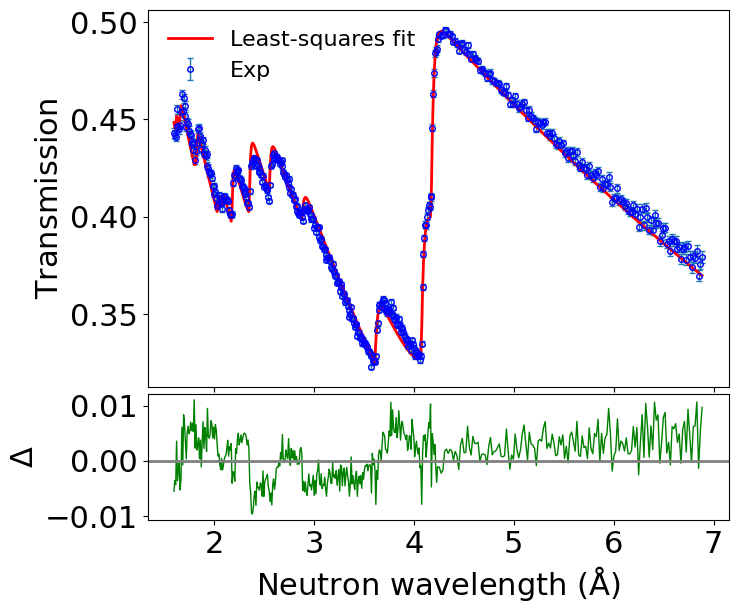

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6),
                               sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 0.25], 'hspace': 0.03})

# Top subplot: Data with error bars and fit line
ax1.errorbar(trans_exp[:, 0], trans_exp[:, 1], yerr=trans_exp[:, 2],
             fmt='o', markerfacecolor='none', markeredgecolor='blue',
             markersize=4, capsize=2, capthick=1, elinewidth=1,
             label='Exp')

ax1.plot(trans_exp[:, 0], result.best_fit,
         color='red', linewidth=2,
         label='Least-squares fit')

# Bottom subplot: Residuals
ax2.plot(trans_exp[:, 0], trans_exp[:, 1] - result.best_fit,
         color='green', linewidth=1)
ax2.axhline(y=0., color='grey', linewidth=2)

# Configure x-axis
ax2.set_xlabel(r'$\mathrm{Neutron\ wavelength\ (\AA)}$', fontsize=22, fontfamily='Times New Roman')

ax1.tick_params(labelsize=22)
ax2.tick_params(labelsize=22)

# Configure y-axes
ax1.set_ylabel(r'$\mathrm{Transmission}$', fontsize=22, fontfamily='Times New Roman')
ax2.set_ylabel(r'$\Delta$', fontsize=22, fontfamily='Times New Roman')

# Legend (similar to your Plotly settings)
ax1.legend(loc='upper left', frameon=True, framealpha=0,
          edgecolor='black', facecolor='white', fontsize=16)

# Set transparent background
fig.patch.set_alpha(0)
ax1.patch.set_alpha(0)
ax2.patch.set_alpha(0)

# Adjust layout margins
plt.tight_layout()
plt.subplots_adjust(left=0.12, right=0.95, bottom=0.1, top=0.95)

# Show/save the figure
plt.show()